In [1]:
# some set-up
from IPython.display import IFrame
from IPython.core.display import display, HTML, SVG
Dataset.Delete('all')
Prop.Setparam('E_SVG_IMAGE',{'asymbol':'compact','frame':False})
Prop.Setparam('E_SVG_IMAGE',{'annotationcolor':'red','annotationfontsize': 10})
Prop.Setparam('D_SVG_IMAGE',{'nrows':-1,'ncols':3,'boxheight':130,'boxwidth':130});

This Jupyter tutorial covers some of the typical problems when implementing a laborarty notebook or similar compound registration system.

## Compound standardization

It is customary to impose encoding standards on compounds being registered. This can either be done by rejecting compoiunds not adhering to the local conventions, or by some background structure modification when they are chedcked in. The prototypical case for this is the encoding of nitro groups. Chemists have never been able to agree whether they should be drawn in a neutral form with pentavalent nitrogen, or with a charged nitrogen and one charged oxygen.

Here is some typical input:

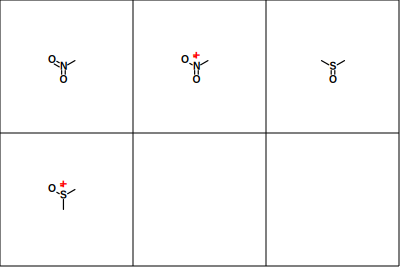

In [2]:

d=Dataset('CN(=O)=O','C[N+](=O)[O-]','CS(=O)C','C[S+]([O-])C')
display(SVG(d.D_SVG_IMAGE))

And in various standadizations:

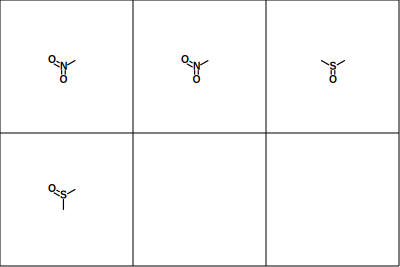

In [3]:
d.nitrostyle('pentavalent')
display(SVG(d.D_SVG_IMAGE))

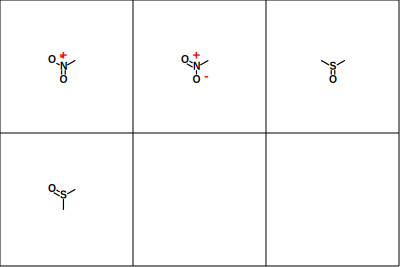

In [4]:
d.nitrostyle('ionic')
display(SVG(d.D_SVG_IMAGE))
# sulfoxides remaining uncharged is intentional. While there is no agreement on how to best
# encode a nitro group, using charges for sulfoxides is rather eccentric.

## Compound sanity check

One important operation when accepting user structures is to verify their chemical sanity. This includes for example valence checks, and stereogenicity verfication in the presence of stereochemistry, or requests for stereochemistry specification or explicit confirmation that a stereo center or bond is undefined in case there are stereogenic atoms or bonds which are not tagged.

Here are some examples. First, valence checks:

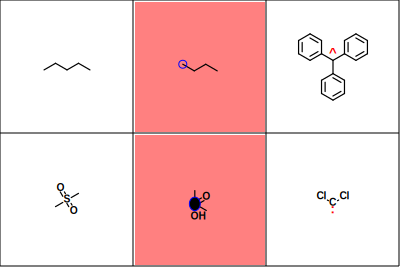

In [10]:
d=Dataset('CCCCC','[CH2]CCC','[C](c1ccccc1)(c1ccccc1)c1ccccc1','CS(=O)(=O)C','CS(=O)(O)C','[C](Cl)(Cl)')
# the second compound contains a probably incorrect radical, and the fourth a questionable sulfur valence
# we mark the atoms in the third and last compounds to be explicit radicals
d[2].atoms()[0].A_RADICAL = 'doublet'
d[5].atoms()[0].A_RADICAL = 'singlet'
for e in d:
    # the valence check command returns the number of atoms with questionable valence
    if e.valcheck('badatoms')>0:
        e.E_COLOR = '#FF8080'
        for a in badatoms:
            a.set('A_FLAGS','+circle')
display(SVG(d.D_SVG_IMAGE))

Nowfor some bond stereochemistry checks.

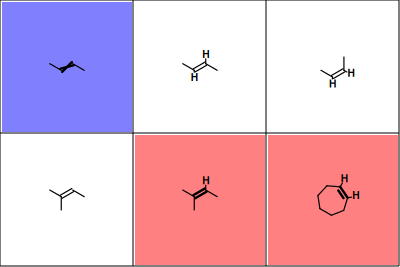

In [24]:
d=Dataset('CC=CC','C/C=C/C','C/C=C\C','CC(C)=CC','C/C(C)=C/C','C1C/C=C/CCC1')
# the first molecule contains a stereogenic double bond with no stereo descriptor.
# The last two molecules are a compound with a non-stereogenic double bond with specifid
# stereochemistry, followed by a compound where the bond stereochemistry is locked
# by the ring size
for e in d:
    for b in e.bonds():
        if (b.filter('bstereogenic')):
            if (not b.nget('B_LABEL_STEREO')):
                # mark record with stereogenic but unspecified bonds in blue
                e.E_COLOR= '#8080FF'
                b.set('B_FLAGS','+fat')
        else:
            if (b.nget('B_LABEL_STEREO')):
                # mark records with spurious specified stereochemistry in red
                e.E_COLOR = '#FF8080'
                b.set('B_FLAGS','+fat')

display(SVG(d.D_SVG_IMAGE))

## Parent compounds

In many cases, the exact salt form or other structure variation is of no concern when looking for a specific compound. A standard technology to make this easily handled is to derive a so-called parent compound from the registration entry, and store this variant side my side with the original structure.

The standard operations performed to get the parent structure usually include removing counterion salts, metal ions, protons (but not other substituents) at positively charged center, deduplication of multiple identical fragments after these operations, protonation of open negatively charged atoms, etc. In some applications, protective groups can also be removed, but that usually requires a configurable definition of what exactly constitutes a protecting group. For example, depending on the context, an ester may be the very structure, or a protected carboxyl group.

Here are some basic examples:

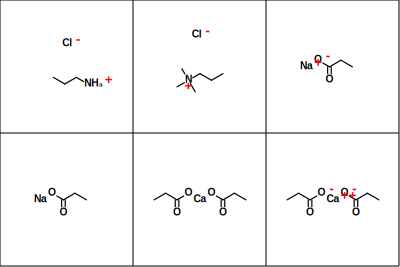

In [21]:
d=Dataset('CCC[NH3+].[Cl-]','CCC[N+](C)(C)C.[Cl-]','CCC(=O)[O-].[Na+]',
    'CCC(=O)O[Na]','CCC(=O)O[Ca]OC(=O)CC','CCC(=O)[O-].[Ca++].[O-]C(=O)CC')
display(SVG(d.D_SVG_IMAGE))

Nor for the parent structures:

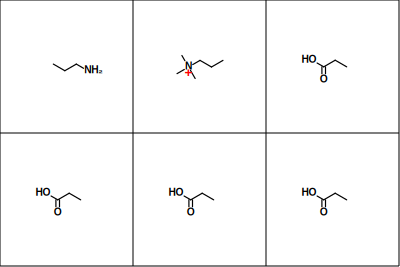

In [22]:
d2=Dataset(d.E_PARENT_STRUCTURE)
d2.new('A_XY')
display(SVG(d2.D_SVG_IMAGE))

As you can see, all counterions and metals have been removed. Additionally, deprotonation happened at the first example, and protonation of the oxygen anions. Note that encoding variants for salts, such as bonds to metals vs. ionic encoding, does not have an effect. Furthermore, compounds which after initial cleanup steps have multiple fragments are reduced to a single instance of that fragment.

Parent compounds are a very useful concept. Most practical queries in a registration system will be performed on these, not the original structures, because the exact salt form etc. is not of concern.

## Compound identity - first steps

Having a primary key to quickly find a compound based on its structure (as drawn by a structure editor, etc.) is a basic requirement for any type of compound management system. In a database context, this works by a fully indexed lookup on some constant string or number which does not depend on atom numbering and similar internal configuration of the drawn query structure. There are two popular techniques for this: Canonic encoding, and hash codes.

A canonic encoding encodes a structure in a decodable format, but with atoms and bonds in a standard bond order, and with standard bond types and other attributes which influence the outcome of the final string. The most commonly encountered formats of this are Canonic SMILES strings (also called Unique SMILES), and the InChI string. However, the original publication describing Canonic SMILES was very incomplete. It did not cover very basic issues like stereochemistry or isotope labelling. As a consequence, Canonic SMILES is highly dependent on the software used to compute it.

The second methods are hash codes. This is a number computed from the structure, which is not intended to be decodable like SMILES or (inofficially) InChI. In theory, hash codes have the disadvantage that they can collide. This means, two different structures could produce the same hash code, which is inadvertable due to the unlimited space of possible structure vs. the limited number range of the hash code. Nevertheless, for practical applications this is not an issue. Structure hash codes should use at least 64 bits (usable with confidence for multi-million record databases), with a preference for 128 bits (continues to work for multi-billion entry counts). In a database, this could for example be encoded as an unsigned long, a fixed-length hex string, or a UUID.

Here is an example:



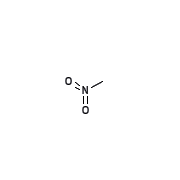
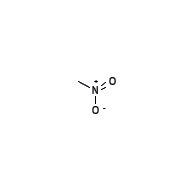

In [23]:
t=Table()
t.addcol('image','Structure')
t.addcol('E_HASHY','64-bit hash')
t.addcol('E_HASH128','128-bit hash')
t.addcol('E_SMILES','Canonic Smiles')
t.addcol('E_STDINCHI','Standard InChI')
t.addcol('E_STDINCHIKEY','InChI Key')
d=Dataset('CN(=O)=O','O=[N+](C)[O-]')
d.new('E_SMILES',parameters={'unique':True})
t.adddataset(d)
t.write('keys.html')
display(HTML(filename='keys.html'))


As can be seen, SMILES can be problematic because there is no way to hide encoding variations like the valence and charge of the nitro group. InChI implicitly fixes this - but at the price of losing exact decodability, i.e. if that InChI string is decoded, the result is always the uncharged form.

But there are more difficult molecules to be aware of. One popular example are a family of compounds called sydnones (https://de.wikipedia.org/wiki/Sydnone, https://en.wikipedia.org/wiki/Sydnone, only the German version has a full depiction set). These cannot be written in an uncharged form without violating basic valence bond rules, and there is no general agreement where the charges should best be placed, so you find all variants in the wild. Sydnones are useful synthesis starting materials, and there are even approved drugs which contain the core structure, so this is not a hypothetical example. Here is the set of variations how a sydnone can reasonably be drawn:

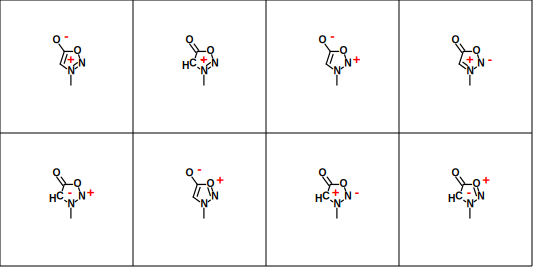

In [25]:
Prop.Setparam('D_SVG_IMAGE',{'ncols':4})
d=Ens('[O-]C1=C[N+](C)=NO1').E_MESOMER_SET
display(SVG(d.D_SVG_IMAGE))

The second column in the first row unfortunately puts the plus sign on the nitrogen and the minus sign on the carbon to the left over each other. Now, let's see how the keys look like for this structure set:


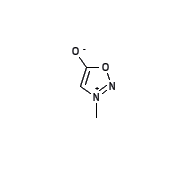
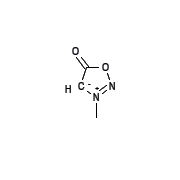
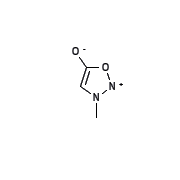
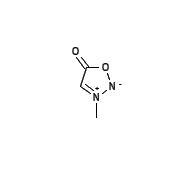
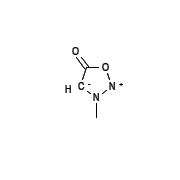
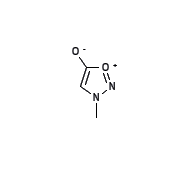
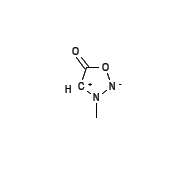
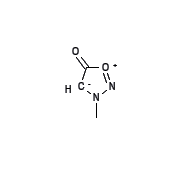

In [26]:
t.set('nrows',0)
d.new('E_SMILES',parameters={'unique':True})
t.adddataset(d)
t.write('keys.html')
display(HTML(filename='keys.html'))

We already know that Canonic SMILES has an unavoidable problem with charges, but for the third of the variants, the InChI stri ng computation also gets lead astray in its attempt to get things under control, and consequently the InChIKey is similarily affected, because it is simply a hash of the InChI string. Computing a really reliable hash code is not trivial.

## Compound identity beyond simple connectivity


## Structure storage

So you have decided to store the molecule record as SMILES - a nice, compact, and easily parseable format. However, if you do so, there are some pitfalls to avoid.
